# Bayesian JAGS model for predicting heart disease

## Problem Statement
In this mini project, we use a clinical dataset to predict whether a patient with a given set of symptoms and test results is at risk of a heart disease or not.

## Dataset
We will use the Statlog (Heart) Data Set from UCI machine Learning Repository:
https://archive.ics.uci.edu/ml/datasets/Statlog+%28Heart%29

In [20]:
dat = read.csv("heart.dat", sep="", header=FALSE)

In [21]:
dim(dat)

[1] 270  14

In [133]:
# Data Set Information:
# -- 1. age
# -- 2. sex
# -- 3. chest pain type (4 values)
# -- 4. resting blood pressure
# -- 5. serum cholestoral in mg/dl
# -- 6. fasting blood sugar > 120 mg/dl
# -- 7. resting electrocardiographic results (values 0,1,2)
# -- 8. maximum heart rate achieved
# -- 9. exercise induced angina
# -- 10. oldpeak = ST depression induced by exercise relative to rest
# -- 11. the slope of the peak exercise ST segment
# -- 12. number of major vessels (0-3) colored by flourosopy
# -- 13. thal: 3 = normal; 6 = fixed defect; 7 = reversable defect
# -- 14. Absence (1) or presence (2) of heart disease

# Variable to be predicted: 14

# data types
# -----------------
# Real: 1,4,5,8,10,12
# Ordered:11,
# Binary: 2,6,9,14
# Nominal:7,3,13
head(dat)

,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,V11,V12,V13,V14
,<dbl>,<fct>,<fct>,<dbl>,<dbl>,<fct>,<fct>,<dbl>,<fct>,<dbl>,<dbl>,<dbl>,<fct>,<fct>
1,70,1,4,130,322,0,2,109,0,2.4,2,3,3,2
2,67,0,3,115,564,0,2,160,0,1.6,2,0,7,1
3,57,1,2,124,261,0,0,141,0,0.3,1,0,7,2
4,64,1,4,128,263,0,0,105,1,0.2,2,1,7,1
5,74,0,2,120,269,0,2,121,1,0.2,1,1,3,1
6,65,1,4,120,177,0,0,140,0,0.4,1,0,7,1


In [135]:
# change datatype of categorical variables
# Binary: 2,6,9
# Nominal:7,3,13
dat$V2 = factor(dat$V2)
dat$V6 = factor(dat$V6)
dat$V9 = factor(dat$V9)
dat$V7 = factor(dat$V7)
dat$V3 = factor(dat$V3)
dat$V13 = factor(dat$V13)
# str(dat)

## Explore Data

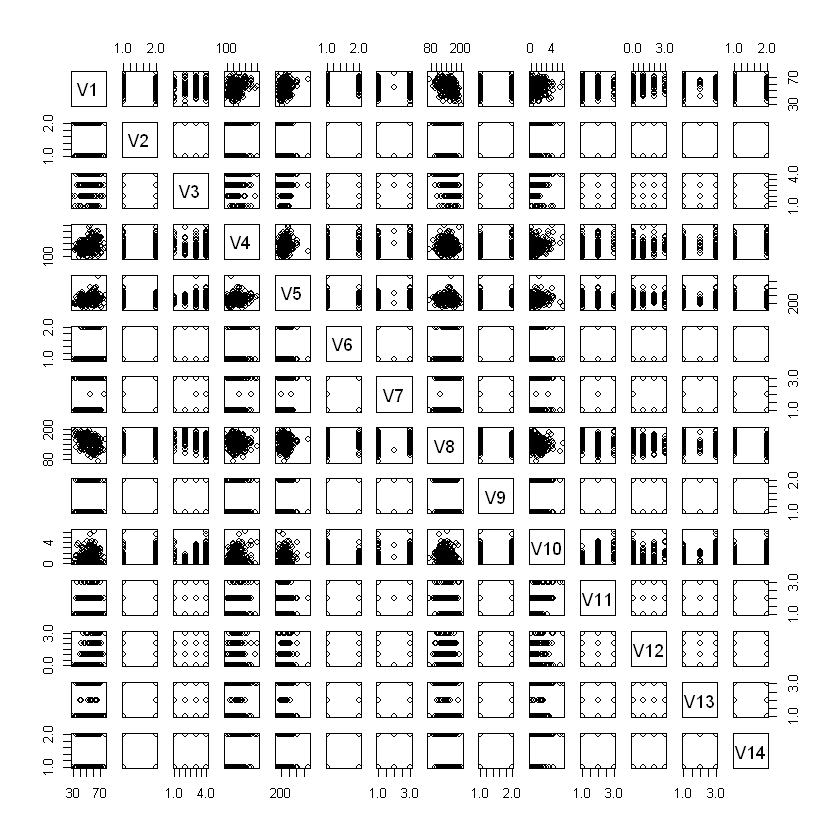

In [27]:
pairs(dat)

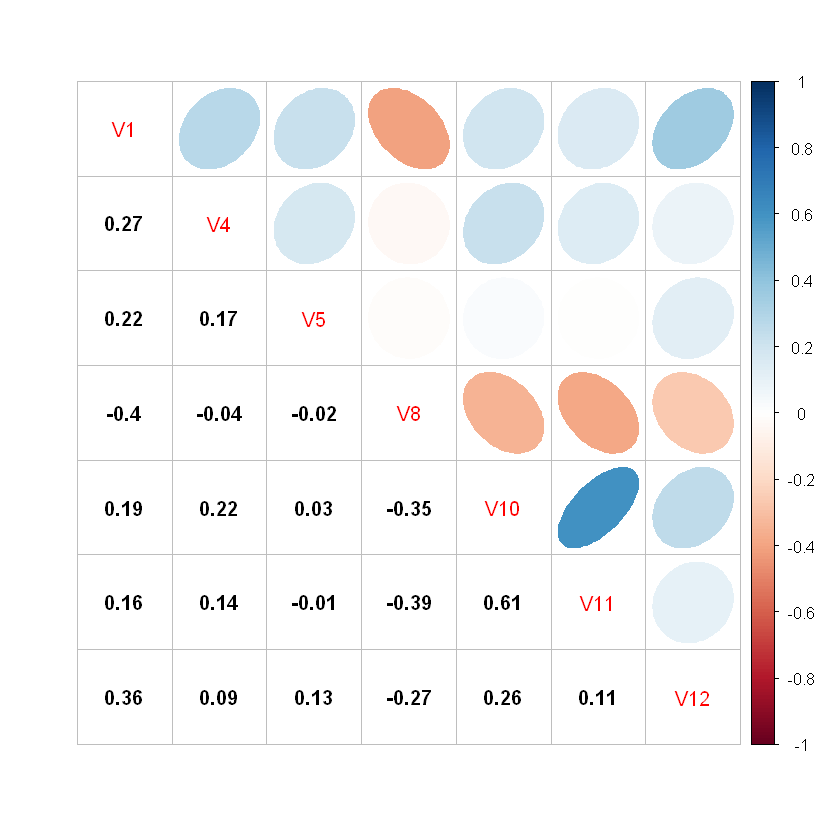

In [136]:
library("corrplot")
Cor = cor(dat[,c(1,4,5,8,10,11,12)])
corrplot(Cor, type="upper", method="ellipse", tl.pos="d")
corrplot(Cor, type="lower", method="number", col="black", 
         add=TRUE, diag=FALSE, tl.pos="n", cl.pos="n")

As we can see, there is high correlation between V8 and V1, and between V10 and V11. When we build our model in the subsequent sections, we will drop V8 and V11 from the the set of features. Now let's look at the categorical variables.

In [138]:
table(dat$V14, dat$V2)
table(dat$V14, dat$V3)

   
      0   1
  1  67  83
  2  20 100

   
     1  2  3  4
  1 15 35 62 38
  2  5  7 17 91

The tabulated data above show that different levels of V2 and V3 have an apparent effect on the response V14.

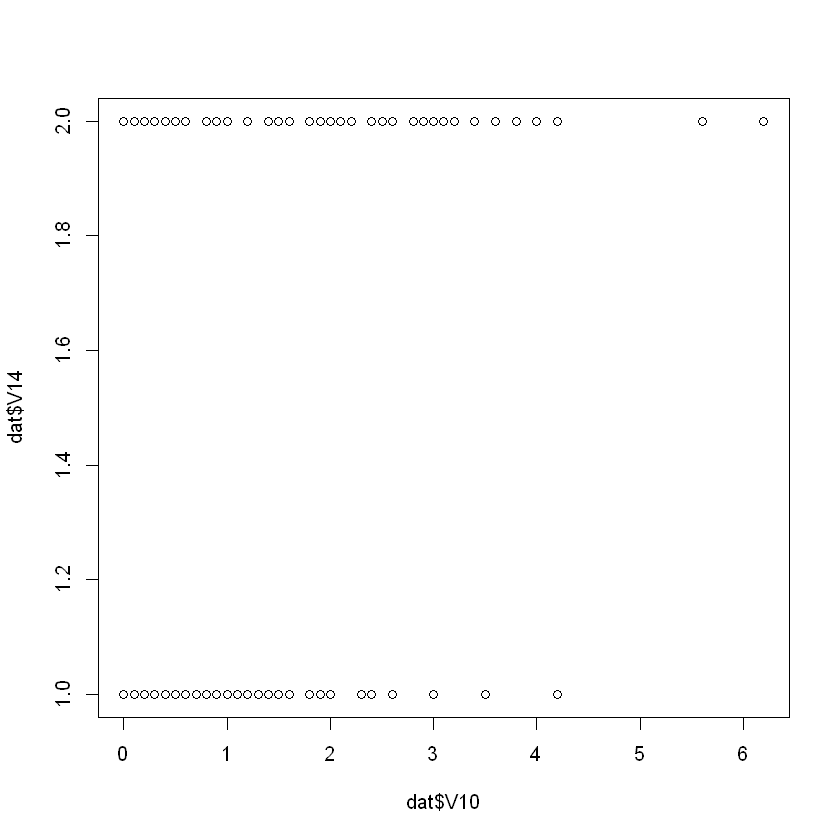

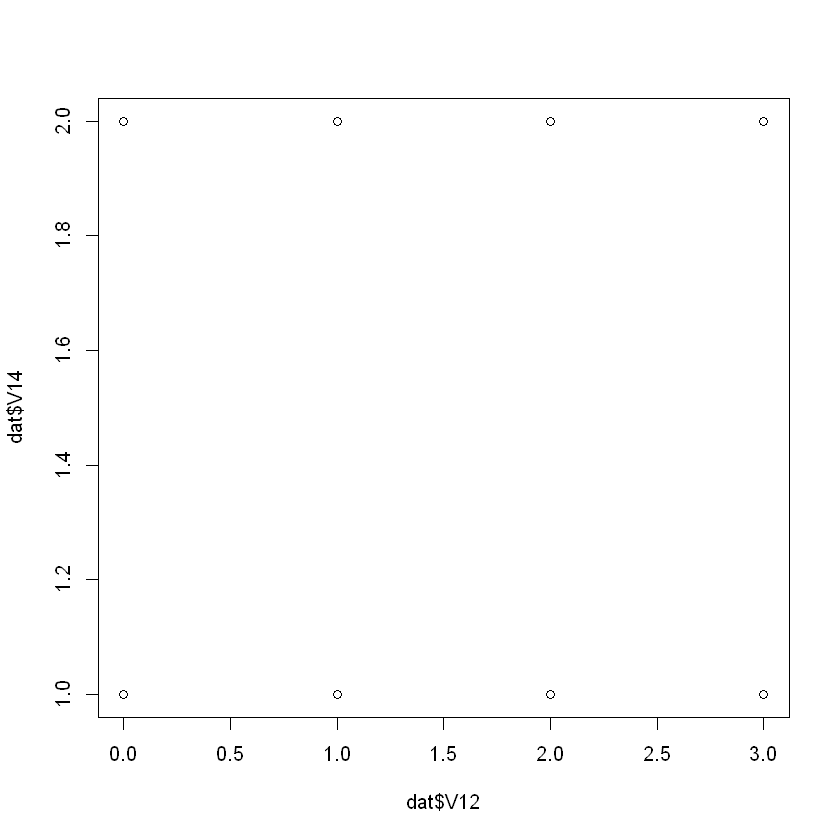

In [139]:
plot(dat$V10 , dat$V14)
plot(dat$V12 , dat$V14)

From the above graphs, we can see that V10 has a noticable effect on the reponse. The effect of V12 on the reponse, however, is not clear.

## Postulate a model
For this purpose, we will use a logistic regression model. Before building the Baysian JAGS model, let's first build a general linear model so we can do a bit of feature engineering before moving forward. <br>
Let's begin by using all uncorrelated variables.

In [140]:
glm.fit <- glm(V14 ~ V1+V2+V3+V4+V5+V6+V7+V9+V10+V12+V13, data = dat, family = binomial)

In [141]:
summary(glm.fit)


Call:
glm(formula = V14 ~ V1 + V2 + V3 + V4 + V5 + V6 + V7 + V9 + V10 + 
    V12 + V13, family = binomial, data = dat)

Deviance Residuals: 
    Min       1Q   Median       3Q      Max  
-2.3433  -0.5041  -0.1585   0.3731   2.8062  

Coefficients:
             Estimate Std. Error z value Pr(>|z|)    
(Intercept) -9.799617   2.409710  -4.067 4.77e-05 ***
V1           0.007967   0.023756   0.335 0.737332    
V21          1.513877   0.556876   2.719 0.006558 ** 
V32          1.255106   0.865292   1.450 0.146919    
V33          0.582397   0.732824   0.795 0.426771    
V34          2.449066   0.732386   3.344 0.000826 ***
V4           0.018618   0.011719   1.589 0.112131    
V5           0.005763   0.003977   1.449 0.147284    
V61         -0.362671   0.596545  -0.608 0.543219    
V71          1.324650   3.112516   0.426 0.670408    
V72          0.720362   0.398181   1.809 0.070430 .  
V91          0.834453   0.436812   1.910 0.056091 .  
V10          0.680540   0.216950   3.137 0.001708

As can be seen, many of the coeficients of the general linear model are insignificant. Only the coeficients of V1, V21, V34, V10, V12 and V13 seem to be significant. Note that upon transoforming to dummy variables, the categorical varibales have been renamed: V21 is the dummy variable (indicator) for V2 == 1, V32 is V3 == 2, V136 is V13 == 6, and so on. We are going to just focus on the variables that we found to be significant here and move to the Bayesian modeling. Before doing so, let's just have a look at how the general linear model does in terms of the predictions.

In [146]:
# predict probabilities
glm.probs <- predict(glm.fit,type = "response")
glm.pred <- ifelse(glm.probs > 0.5, 2, 1)

In [147]:
# model Accuracy
mean(glm.pred == dat$V14)

[1] 0.8592593

So we get 85% of accuracy, but we also used almost all of the variables in this baseline model, so there might be some overfitting. We won't address overfitting in this project.

In [150]:
# False negatives are vey important here
# the confusion matrix
table(glm.pred,dat$V14)

        
glm.pred   1   2
       1 135  23
       2  15  97

In [151]:
# false negative rate
25/270

[1] 0.09259259

Of course, We will get a better false negative rate if we lower the threshold. We will experiment with it in the Bayesian model. 

### Model

Let's postulate the following logistic regression model: <br>
$y_i|p_i \sim Bern(p_i), i = 1, 2, ..., n$ <br>
$log\left( \frac{p_i}{1 - p_i} \right) = b_0 + b_{21}V_{21}(i) + b_{32}V_{32}(i) + b_{33}V_{33}(i) + b_{34}V_{34}(i) + b_{10}V_{10}(i) + b_{12}V_{12}(i) + b_{136}V_{136}(i) + b_{137}V_{137}(i)$ <br>
where $V_{10}$ and $V_{12}$ are real valued covariates and $V_{21}$, $V_{32}$, $V_{33}$, $V_{34}$, $V_{136}$, $V_{137}$ are dummy (one-hot encoded) covariates, and <br>
$b_0$ has normal distribution and each of $b_{21}, ..., b_{137}$ has a double exponential distribution.

## Fit the model using JAGS

In [152]:
library("rjags")
# scale and center numeric features 
library(MASS)
# sdat contains scaled data
sdat = dat
numeric_columns <- sapply(sdat, is.numeric)
sdat[numeric_columns] <- lapply(sdat[numeric_columns], scale)
# observe that the data is both scaled and centered
# colMeans(sdat[numeric_columns])
# apply(sdat[numeric_columns], 2, sd)

In [153]:
# One-hot encode categorical data in X1
X1 = model.matrix( ~ V2 + V3 + V10 + V12 + V13, data=sdat)

# JAGS logistic regression works with response 0, 1
y = as.numeric(sdat$V14) - 1
#head(X1)

Compiling model graph
   Resolving undeclared variables
   Allocating nodes
Graph information:
   Observed stochastic nodes: 270
   Unobserved stochastic nodes: 9
   Total graph size: 2868

Initializing model



Potential scale reduction factors:

     Point est. Upper C.I.
b0         1.01       1.01
b10        1.00       1.00
b12        1.00       1.00
b136       1.00       1.00
b137       1.00       1.00
b21        1.00       1.00
b32        1.00       1.00
b33        1.00       1.00
b34        1.00       1.01

Multivariate psrf

1

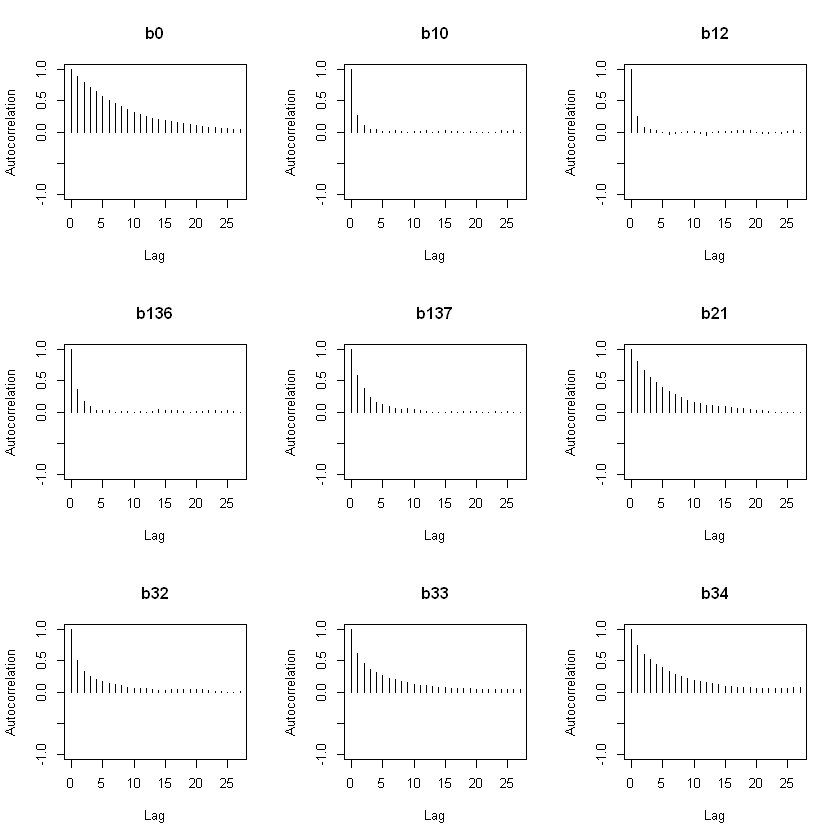

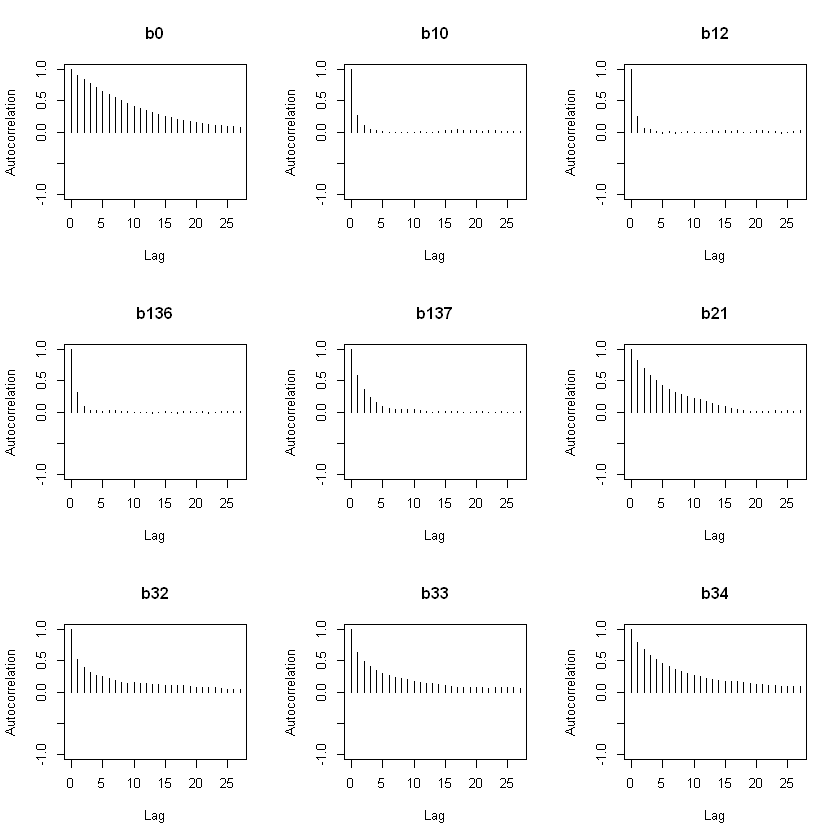

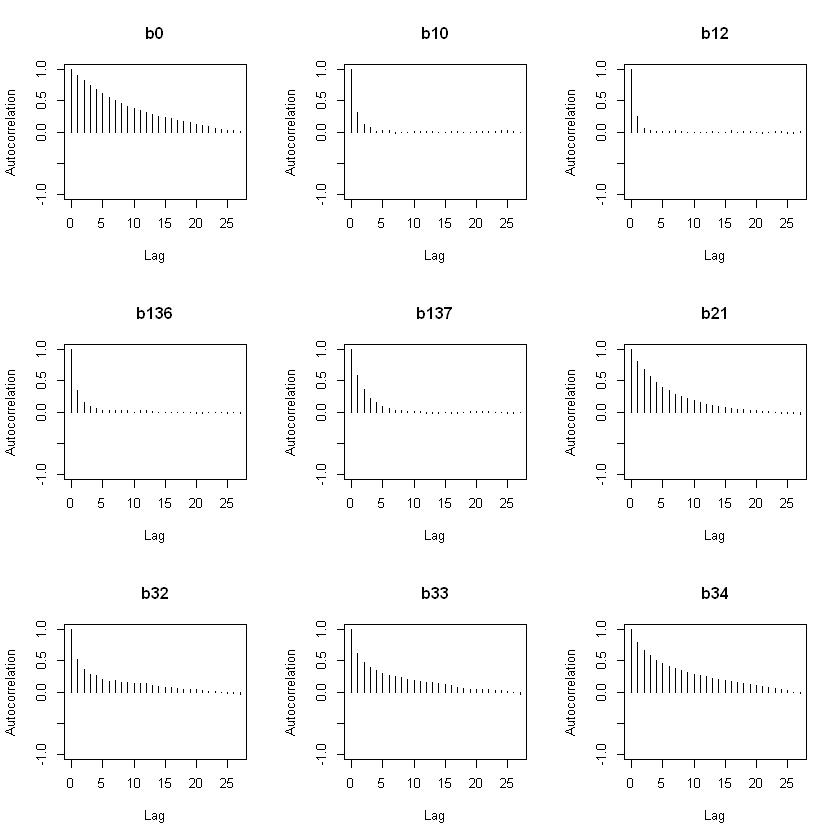

In [156]:
mod1_string = " model {
    for (i in 1:length(y)) {
        y[i] ~ dbern(p[i])
        logit(p[i]) = (b0 + b21*V21[i] + b32*V32[i] + b33*V33[i] + b34*V34[i] + b10*V10[i] + b12*V12[i] + 
                        b136*V136[i] + b137*V137[i] )
    }

    b0 ~ dnorm(0.0, 1.0/25.0)    
    b21 ~ ddexp(0.0, sqrt(2.0)) # has variance 1.0
    b32 ~ ddexp(0.0, sqrt(2.0))
    b33 ~ ddexp(0.0, sqrt(2.0))
    b34 ~ ddexp(0.0, sqrt(2.0))
    b10 ~ ddexp(0.0, sqrt(2.0))
    b12 ~ ddexp(0.0, sqrt(2.0))
    b136 ~ ddexp(0.0, sqrt(2.0))
    b137 ~ ddexp(0.0, sqrt(2.0))
} "


data1_jags = list(y=y, V21=X1[,"V21"], V32=X1[,"V32"], V33=X1[,"V33"], V34=X1[,"V34"], V10=X1[,"V10"], V12=X1[,"V12"]
                , V136=X1[,"V136"], V137=X1[,"V137"])

params1 = c("b0", "b21", "b32", "b33", "b34", "b10", "b12", "b136", "b137")

mod1 = jags.model(textConnection(mod1_string), data=data1_jags, n.chains=3)
update(mod1, 1e3)

mod1_sim = coda.samples(model=mod1,
                        variable.names=params1,
                        n.iter=5e3)
mod1_csim = as.mcmc(do.call(rbind, mod1_sim))

## convergence diagnostics
# plot(mod1_sim, ask=TRUE)

gelman.diag(mod1_sim)
#autocorr.diag(mod1_sim)
autocorr.plot(mod1_sim)
#effectiveSize(mod1_sim)

## calculate DIC
dic1 = dic.samples(mod1, n.iter=1e3)

I have commented out parts of the convergence checks, but as can bee seen they look pretty good. 

#### Check model summary

In [106]:
summary(mod1_sim)


Iterations = 2001:7000
Thinning interval = 1 
Number of chains = 3 
Sample size per chain = 5000 

1. Empirical mean and standard deviation for each variable,
   plus standard error of the mean:

        Mean     SD Naive SE Time-series SE
b0   -2.2288 0.5071 0.004140       0.018371
b10   0.7907 0.2080 0.001698       0.002329
b12   0.9656 0.2103 0.001717       0.002279
b136  0.3258 0.5294 0.004323       0.006512
b137  1.5275 0.3899 0.003184       0.006527
b21   0.8202 0.4256 0.003475       0.011091
b32   0.1733 0.4842 0.003954       0.010376
b33  -0.1853 0.4329 0.003535       0.010438
b34   1.7680 0.4692 0.003831       0.013450

2. Quantiles for each variable:

         2.5%      25%     50%      75%   97.5%
b0   -3.23066 -2.56939 -2.2211 -1.87756 -1.2747
b10   0.38904  0.64826  0.7870  0.92901  1.2130
b12   0.56702  0.82189  0.9589  1.10345  1.3943
b136 -0.63319 -0.02531  0.2755  0.64918  1.4794
b137  0.78794  1.25745  1.5202  1.78522  2.3097
b21   0.02125  0.52866  0.8121  1.10570  

## Check the model
We have seen the convergence information above. Let's look at the coeficients too.

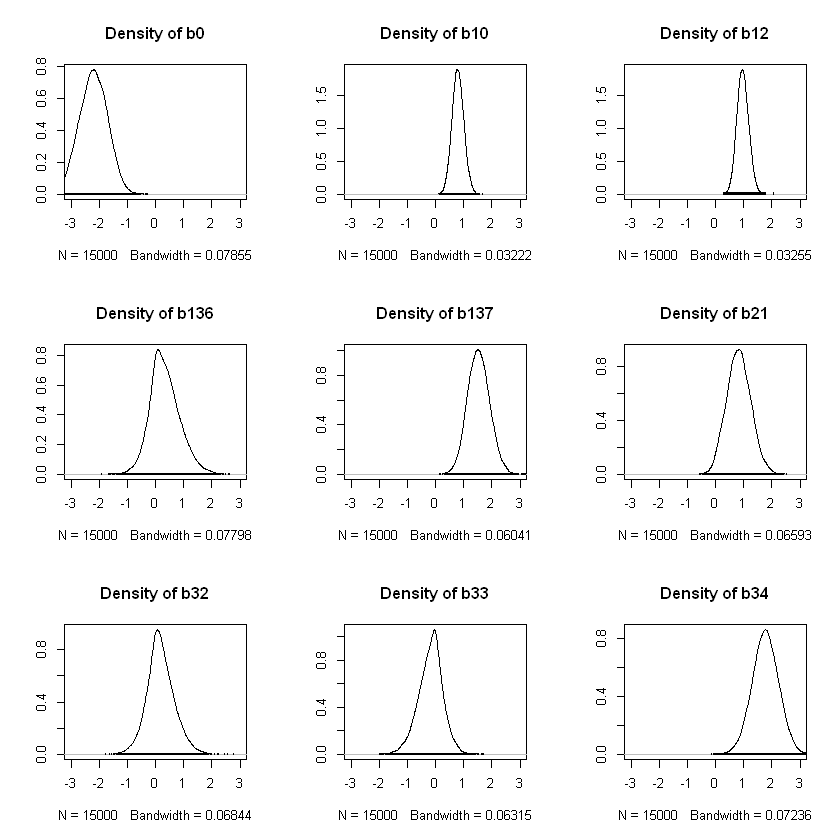

In [107]:
par(mfrow=c(3,3))
densplot(mod1_csim[,1:9], xlim=c(-3.0, 3.0))

## Iterate
We have already iterated and did some feature engineering when we built the general linear model. Although strictly speaking it might be arguable to use the result of that analysis here, we can argue that the general linear model and the Bayesian model are infact very similiar. We used a bernoulli likelihood and independent double exponential distributions for the coeficients in the Bayesian model, whereas in the general linear model independent normal distributions for the coeficients are assumed. As we will see below, the results of the two models are very similar. So we can take the general linear model as one of our  iterations. There is one more thing we can do here, and that is the above plots show that b136, b32 and b33 are most probably not significant and we can remove them from the model. I will skipp it and go ahead to check the predictions. 

### Check accuracy and the false negative rate

In [157]:
# first, we need the coeficients, which we can get from the Monte Carlo MArkov Chain simulation result.
(pm_coef = colMeans(mod1_csim))

b0        b10        b12       b136       b137        b21        b32 
-2.2368626  0.7885256  0.9637431  0.3071447  1.5144342  0.8363093  0.1798134 
       b33        b34 
-0.1855816  1.7699258

In [158]:
pm1_Xb = X1 %*% pm_coef
phat1 = 1.0 / (1.0 + exp(-pm1_Xb))
#head(phat1)

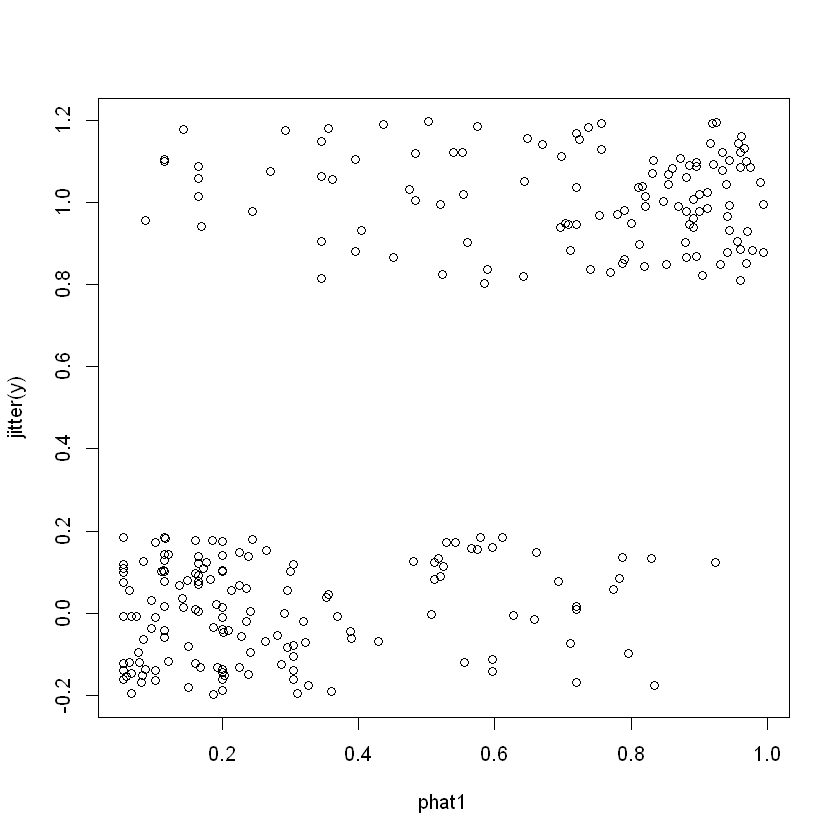

In [159]:
# predicted probabilities
plot(phat1, jitter(y))

In [160]:
pred1 <- ifelse(phat1 > 0.5, 1, 0)
# confusion matrix
table(pred, y)

    y
pred   0   1
   0 119  25
   1  31  95

In [161]:
# accuracy
mean(pred1 == y)

[1] 0.7925926

In [162]:
# False negatives
25/270

[1] 0.09259259

Let's lower the threshold to improve the false negative rate. Note that the accuracy is also improved. Full investigation of this effect requires building an ROC which I won't do here.

In [164]:
pred1 <- ifelse(phat1 > 0.4, 1, 0)
table(pred1, y)
mean(pred1 == y)

     y
pred1   0   1
    0 117  19
    1  33 101

[1] 0.8074074

**These results are good enough for this practice so I won't iterate further to improve this model.**

## Use model

Let's demonstrate a very simple use case. Consider a male patient (V21 = 0), with chest pain type V3 = 3 (V32 = 0, V33 = 1, V34 = 0), oldpeak V10= 1.6 (scaled to 0.48), number of major vessles V12 = 3 (scaled to 2.47), and V13 = 6 (fixed defect V136 = 1, V137 = 0). Let's predict if this patient will have a heart disease. 

In [175]:
# add 1 as the intercept as the first element to x
x = c(1, 0, 0, 1, 0, 0.48, 2.47, 1, 0)
logit = x %*% pm_coef
p = 1.0 / (1.0 + exp(-logit))
(pred <- ifelse(p > 0.4, 'has disease', 'no disease'))

no disease
